In [217]:
import sys

sys.path.append("../../../../XRaySimulation2")

import numpy as np
import matplotlib.pyplot as plt
from XRaySimulation import util, Pulse, Crystal, Alignment, Efficiency, RockingCurve

In [218]:
Ec = 9.8  # keV
wavelength = 2 * np.pi / util.kev_to_wavevec_length(Ec)
kin = np.array([-1398.73758358, -19381.33420562, 45704.44855449])

crystal_property = {'d': 1.3806 * 1e-4,
                    "chi0": complex(-0.20135E-04, 0.63853E-06),
                    "chih": complex(0.10376E-04, -0.60756E-06),
                    "chihbar": complex(0.10376E-04, -0.60756E-06),
                    "chih_pi": complex(0.60195E-05, -0.35235E-06),
                    "chihbar_pi": complex(0.60195E-05, -0.35235E-06)}

tilt_angle = np.deg2rad(11.5)
tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))
g_len = np.pi * 2 / crystal_property['d']

sto220 = Crystal.CrystalBlock3D(h=(np.dot(tilt_mat, np.array([g_len, g_len, 0])) / np.sqrt(2)),
                                normal=np.array([- np.cos(tilt_angle), 0, np.sin(tilt_angle)]),
                                surface_point=np.zeros(3, dtype=np.float64),
                                thickness=100,
                                chi_dict=crystal_property,
                                edge_length=5e4, )

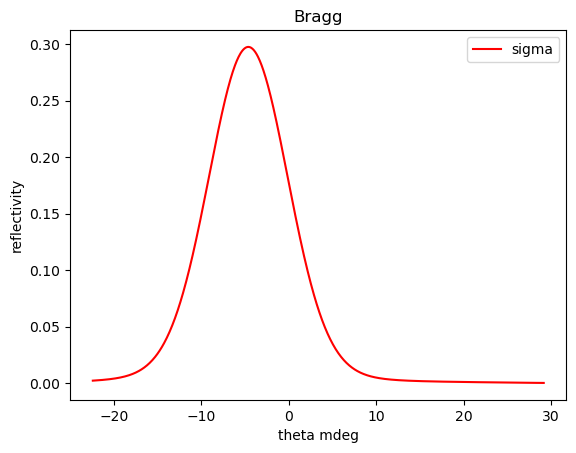

In [220]:
(angles,
 reflect_sigma,
 reflect_pi,
 b_factor,
 kout) = RockingCurve.get_rocking_curve_around_axis(kin=kin,
                                                    scan_range=[2.2671, 2.268],
                                                    scan_number=1000,
                                                    rotation_axis=np.array(
                                                        [- np.cos(tilt_angle), 0, np.sin(tilt_angle)]),
                                                    crystal=sto220, )
efficiency = np.square(np.abs(reflect_sigma)) / np.abs(b_factor)
efficiency_pi = np.square(np.abs(reflect_pi)) / np.abs(b_factor)

theta0 = angles[np.argmax(efficiency)]
theta_sigma = util.fwhm_to_sigma(fwhm= np.deg2rad(10e-3))  # angular divergence in rad
distri = np.exp(-(angles - theta0) ** 2 / 2 / theta_sigma ** 2) / np.sqrt(2 * np.pi) / theta_sigma
distri /= np.sum(distri)

efficiency_new = np.convolve(a=efficiency, v=distri, mode='same')

plt.plot(np.rad2deg(angles - theta0) * 1000, efficiency_new, c='r', label="sigma")
#plt.plot(np.rad2deg(angles - theta0) * 1000, efficiency_pi, c='b', label="pi")
plt.legend()
plt.title("Bragg")
plt.ylabel("reflectivity")
plt.xlabel("theta mdeg")

plt.show()

In [238]:
kin = np.array([-1398.73758358, -19381.33420562, 45704.44855449])
k_tg = np.array([531.17015268, 0., 0.])

scaling = 6e-4
crystal_property = {'d': 1.3806 * 1e-4,
                    "chi0": complex(-0.20135E-04, 0.63853E-06), #* scaling,
                    "chih": complex(0.10376E-04, -0.60756E-06) * scaling,
                    "chihbar": complex(0.10376E-04, -0.60756E-06) * scaling,
                    "chih_pi": complex(0.60195E-05, -0.35235E-06) * scaling,
                    "chihbar_pi": complex(0.60195E-05, -0.35235E-06) * scaling}

tilt_angle = np.deg2rad(11.5)
tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))
g_len = np.pi * 2 / crystal_property['d']

sto220 = Crystal.CrystalBlock3D(h=(np.dot(tilt_mat, np.array([g_len, g_len, 0])) / np.sqrt(2)),
                                normal=np.array([- np.cos(tilt_angle), 0, np.sin(tilt_angle)]),
                                surface_point=np.zeros(3, dtype=np.float64),
                                thickness=2,
                                chi_dict=crystal_property,
                                edge_length=5e4, )

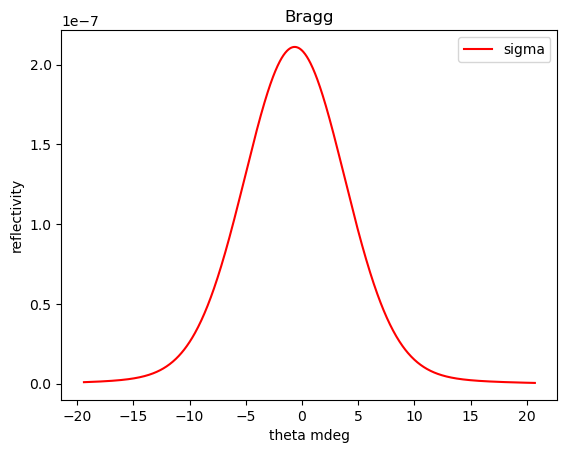

In [239]:
(angles,
 reflect_sigma,
 reflect_pi,
 b_factor,
 kout) = RockingCurve.get_rocking_curve_around_axis(kin=kin + k_tg,
                                                    scan_range=[2.257, 2.2577],
                                                    scan_number=1000,
                                                    rotation_axis=np.array(
                                                        [- np.cos(tilt_angle), 0, np.sin(tilt_angle)]),
                                                    crystal=sto220, )
efficiency = np.square(np.abs(reflect_sigma)) / np.abs(b_factor)
efficiency_pi = np.square(np.abs(reflect_pi)) / np.abs(b_factor)

theta0 = angles[np.argmax(efficiency)]

# Get a gaussian distribution for the angular divergence of the incident X-ray pulse
theta_sigma = util.fwhm_to_sigma(fwhm= np.deg2rad(10e-3))  # angular divergence in rad
distri = np.exp(-(angles - theta0) ** 2 / 2 / theta_sigma ** 2) / np.sqrt(2 * np.pi) / theta_sigma
distri /= np.sum(distri)

efficiency_new = np.convolve(a=efficiency, v=distri, mode='same')

#plt.plot(np.rad2deg(angles - theta0) * 1000, efficiency_new, c='r')
#plt.plot(np.rad2deg(angles - theta0) * 1000, efficiency_pi, c='b')
#plt.plot(angles, efficiency, c='r')
#plt.plot(angles, efficiency_pi, c='b')

plt.plot(np.rad2deg(angles - theta0) * 1000, efficiency_new, c='r', label="sigma")
plt.legend()
plt.title("Bragg")
plt.ylabel("reflectivity")
plt.xlabel("theta mdeg")

plt.show()

In [230]:
u_0 = scaling * 2 / g_len * 1e4
print("{:.2e} A".format(u_0))
print("{:.2e} K".format(u_0 * 1e-4 * k_tg[0] / 11.1e-6))

8.79e-05 A
4.21e-01 K


# Get the temperature difference

In [105]:
volume = 5e-6 * 10e-6 * 31.5e-6 * 1e6  # cm^3
density = 5.11  # g / cm^3
mass = volume * density  # g

mol_density = 183.49  # g/mol
mol_num = mass / mol_density

cp = 98.413  # J/mol/K,  https://www.sciencedirect.com/science/article/pii/S0021961410002557

energy = 10e-6 * 0.3 * 0.9 * 0.6 * 0.5  # 10uJ after XPP mono, 30 % of grating 1, 90 % of miniSD, 60% of grating 2, 50 % of air gap
print("The pump total energy is {:.2f} uJ".format(energy * 1e6))

delta_T = energy / cp / mol_num
print("Temperature increase is {:.2f}K".format(delta_T))

The pump total energy is 0.81 uJ
Temperature increase is 187.65K


In [106]:
distance = 120e3  
wavelength =  np.pi * 2 / util.kev_to_wavevec_length(9.8)
coherent_length = 10 * util.c
pixel_size = 75

factor = (pixel_size * coherent_length / wavelength / distance) ** 2

In [107]:
print(factor)

219.34155700559808


In [242]:
photon_number = 6.24150907e12 / 9.8e3 * energy * 1e6
print("{:.2e}".format(photon_number))

5.16e+08


In [243]:
# Therefore the absolute efficiency is roughly 
18 / photon_number

3.489184672093696e-08